# 12_nndl_cv_mlp2

We will experiment with Neural Networks and Deep Learning on the no_na dataset. This is mlp2, our second version of multi-layer perceptron 

# Difference from mlp1 - no dropout on the input layer

In [ ]:
''' data and math '''
import pandas as pd
import numpy as np

''' plotting images '''
from matplotlib import pyplot as plt
%matplotlib inline

''' traversing directories '''
import os
from pathlib import Path

''' utilities '''
from tqdm import tqdm

''' metrics '''
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve

''' preprocessing '''
from sklearn.preprocessing import StandardScaler

In [ ]:
''' used to reference the root directory, for directory traversal ''' 
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
mount_dir = '/content/gdrive'
root_dir = Path('/content/gdrive/My Drive/it3011_project')

Mounted at /content/gdrive


# Loading data

In [ ]:
# load data
train = pd.read_csv(root_dir/"data/train_no_na.csv")
test = pd.read_csv(root_dir/"data/test_no_na.csv")
print("data loaded")

data loaded


In [ ]:
# check shape
print(train.shape)
print(test.shape)

(279331, 138)
(120163, 138)


In [ ]:
# create train/test sets
features = [feature for feature in test.keys() if "feature" in feature]
x_train = train.loc[:, features].values
y_train = train.loc[:,['action']].values.flatten()
x_test = test.loc[:, features].values
y_test = test.loc[:,['action']].values.flatten()
print("train/test set created")

train/test set created


# Helper functions

In [ ]:
# constants
SEED = 42

# cross validation
from sklearn.model_selection import KFold
kf = KFold(n_splits=10, random_state=SEED, shuffle=True)

In [ ]:
# create the utility score, which takes in the prediction value and the ground truth action and generates a score
# link: https://www.kaggle.com/c/jane-street-market-prediction/overview/evaluation

# data: original train/test data    action: the y-value. can either be y_pred or original values too, if we want the max score attainable
def utility_score(data, action): 
  dates_set = set(data.date.values)
  dates = data.loc[:, ['date']].values.flatten()
  weights = data.loc[:, ['weight']].values.flatten()
  resps = data.loc[:, ['resp']].values.flatten()
  actions = action.flatten()

  i = len(dates_set)
  p_i = []

  for date in dates_set:
    indices = np.where(dates == date)[0]
    p_i_temp = 0
    for j in indices:
      p_i_temp = p_i_temp + weights[j] * resps[j] * actions[j]
    p_i.append(p_i_temp)
  
  p_i_squared = [p_i1*p_i2 for p_i1,p_i2 in zip(p_i,p_i)]
  t = ( sum(p_i) / np.sqrt(sum(p_i_squared)) ) * np.sqrt(250/i)
  u = min(max(t, 0), 6) * sum(p_i)

  return u

def max_train_utility_score(data=train, action=y_train):
  return utility_score(data, action)

def max_test_utility_score(data=test, action=y_test):
  return utility_score(data, action)

In [ ]:
def model_scores(model, test, x_test, y_test):
  y_pred = model.predict(x_test) 
  y_pred = (y_pred > 0.5).astype(int)
  
  # # get some scores from helpers
  utility = utility_score(test, y_pred)
  accuracy =  accuracy_score(y_test, y_pred)

  # # confusion matrix
  # print("confusion matrix")
  cm = confusion_matrix(y_test, y_pred)
  true_pos = cm[1][1]
  true_neg = cm[0][0]
  false_pos = cm[0][1]
  false_neg = cm[1][0]

  # # plot confusion matrix
  # fig, ax = plt.subplots(figsize=(3, 3))
  # ax.imshow(cm)
  # ax.grid(False)
  # ax.xaxis.set(ticks=(0, 1), ticklabels=('Predicted 0s', 'Predicted 1s'))
  # ax.yaxis.set(ticks=(0, 1), ticklabels=('Actual 0s', 'Actual 1s'))
  # ax.set_ylim(1.5, -0.5)
  # for i in range(2):
  #     for j in range(2):
  #         ax.text(j, i, cm[i, j], ha='center', va='center', color='red')
  # plt.show()  

  # # AUC-ROC
  # print("AUC_ROC")
  logit_roc_auc = roc_auc_score(y_test, y_pred)

  # # plot auc-roc
  # fpr, tpr, thresholds = roc_curve(y_test, model.predict_proba(x_test)[:,1])
  # plt.figure()
  # plt.plot(fpr, tpr, label='Logistic Regression (area = %0.2f)' % logit_roc_auc)
  # plt.plot([0, 1], [0, 1],'r--')
  # plt.xlim([0.0, 1.0])
  # plt.ylim([0.0, 1.05])
  # plt.xlabel('False Positive Rate')
  # plt.ylabel('True Positive Rate')
  # plt.title('Receiver operating characteristic')
  # plt.legend(loc="lower right")
  # plt.show()

  return utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg

In [ ]:
import datetime
import csv

def save_scores(output_filename, workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg):
  # create output file if not exists
  try:
    f = open(root_dir/output_filename)
  except IOError:
    with open (root_dir/output_filename, 'a') as csvfile:
      headers = ["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"]
      writer = csv.DictWriter(csvfile, delimiter=',', lineterminator='\n',fieldnames=headers)
      writer.writeheader() 
      print("created output file")  
    csvfile.close()

  # output file exists, append
  timestamp = datetime.datetime.now().strftime("%d/%m/%Y %H:%M:%S")
  
  ''' create another df that looks just like the excel file and concat with ''' 
  new_scores = pd.DataFrame(np.array([[workbook_name, model_name, model_params, utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg, timestamp]]),
                   columns=["workbook_name", "model_name", "model_params", "utility", "accuracy", "logit_roc_auc", "true_pos", "true_neg", "false_pos", "false_neg", "timestamp"],
                  )

  new_scores.to_csv(root_dir/output_filename, mode='a', header=False, index=False)
  print("saved model metrics")

In [ ]:
'''
used to generate the PosixPath variables for the results to save
'''
def results_paths(root_dir=root_dir):
    PATH_RESULTS = root_dir /'results_nndl'
    PATH_HISTORIES = PATH_RESULTS / 'histories'
    PATH_FIGURES = PATH_RESULTS / 'figures'
    PATH_CHECKPOINTS = PATH_RESULTS / 'checkpoints'
    PATH_PREDICTIONS = PATH_RESULTS / 'predictions'

    return PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS


''' 
used to save the history of a model as a npy file
'''
# filename like 'history/model_name.npy'
def history_saver(history, model_name, history_save_path, already_npy=False):
  history_json = {}

  if already_npy:
    history_npy = history
  else:
    history_npy = history.history

  np.save(history_save_path/model_name, history_npy)
  print("History saved")



''' 
used to load the history of a model from a npy file
'''
# filename like 'history/model_name.npy'
def history_loader(model_name, history_save_path):
  history_save_path = history_save_path/str(model_name+'.npy')
  history=np.load(history_save_path,allow_pickle='TRUE').item()
  print('History loaded')
  
  return history 

'''
used to plot the metrics for a given history
'''
def plot_metrics(history, model_name, figure_save_path):
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(18, 6))

    # print(history.keys())

    # plot losses
    train_loss = history['loss']
    val_loss = history['val_loss']
    loss_title = 'loss against epochs'

    ax1.plot(train_loss, label='train')
    ax1.plot(val_loss, label='val')
    ax1.set_title(loss_title)
    ax1.set_ylabel('loss')
    ax1.set_xlabel('epochs')
    ax1.legend()

    # plot accuracy_score
    accuracy_score = history['accuracy']
    val_accuracy_score = history['val_accuracy']
    accuracy_score_title = 'accuracy_score against epochs'

    ax2.plot(accuracy_score, label='train')
    ax2.plot(val_accuracy_score, label='val')
    ax2.set_title(accuracy_score_title)
    ax2.set_ylabel('accuracy_score')
    ax2.set_xlabel('epochs')
    ax2.legend()


    # plot accuracy_score
    auc_score = history['auc']
    val_auc_score = history['val_auc']
    auc_score_title = 'auc_score against epochs'

    ax3.plot(auc_score, label='train')
    ax3.plot(val_auc_score, label='val')
    ax3.set_title(auc_score_title)
    ax3.set_ylabel('auc_score')
    ax3.set_xlabel('epochs')
    ax3.legend()


    # save figure
    fig.suptitle('Metrics for model: ' + model_name)
    plt.savefig(figure_save_path/f'{model_name}.png')

    plt.show()  

# Neural Network - Model 2 (Epochs)

In [ ]:
!pip install keras_tqdm

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras

from keras_tqdm import TQDMCallback
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.layers import Input, Dense, BatchNormalization, Dropout, Activation
from keras.layers.experimental.preprocessing import Normalization
from keras.models import Model, Sequential
from keras.losses import BinaryCrossentropy
from keras.optimizers import Adam
from keras.metrics import BinaryAccuracy, AUC

tf.random.set_seed(SEED)
np.random.seed(SEED)

In [ ]:
PATH_RESULTS, PATH_HISTORIES, PATH_FIGURES, PATH_CHECKPOINTS, PATH_PREDICTIONS = results_paths()

In [ ]:
def create_mlp(num_columns, hidden_units, activation, dropout_rates, learning_rate): 
  inp = Input(shape=(num_columns,))
  x = BatchNormalization()(inp)

  for i in range(len(hidden_units)):   
    x = Dense(hidden_units[i])(x)
    x = Activation(activation)(x)
    x = BatchNormalization()(x)
    x = Dropout(dropout_rates[i])(x)

  x = Dense(1)(x)
  out = Activation("sigmoid")(x)

  model = Model(inputs=inp, outputs=out)

  model.compile(
    optimizer=Adam(learning_rate=learning_rate),
    loss=BinaryCrossentropy(label_smoothing=1e-4),
    metrics=[BinaryAccuracy(name="accuracy"), AUC(name="auc")]
  )

  return model

In [ ]:
# settings to vary

# epochs default = 100
epochs = [50, 100, 400] 

# batch_sizes default = [1024]
batch_sizes = [1024]

# hidden_units default = [100, 200, 400, 200]
hidden_units = [
    [100, 200, 400, 200]
]

# dropout_rates should have same number of values as hidden_units
# dropout_rates default = [0.2, 0.2, 0.2, 0.2]
dropout_rates = [
    [0.2, 0.2, 0.2, 0.2]
] 

# activations default = [tf.keras.activations.relu]
activations = [tf.keras.activations.relu]

# learning_rates default = [1e-4]
learning_rates = [1e-4]


model_name:  mlp2_epochs_50
model_params:  batch_size=1024, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7fd243ec2200>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=50
training model fold 1
Epoch 1/50
246/246 [==============================] - 4s 9ms/step - loss: 0.8248 - accuracy: 0.5034 - auc: 0.5041 - val_loss: 0.6962 - val_accuracy: 0.5209 - val_auc: 0.5295
Epoch 2/50
246/246 [==============================] - 2s 6ms/step - loss: 0.7567 - accuracy: 0.5076 - auc: 0.5116 - val_loss: 0.6943 - val_accuracy: 0.5275 - val_auc: 0.5404
Epoch 3/50
246/246 [==============================] - 2s 6ms/step - loss: 0.7381 - accuracy: 0.5130 - auc: 0.5179 - val_loss: 0.6907 - val_accuracy: 0.5326 - val_auc: 0.5478
Epoch 4/50
246/246 [==============================] - 2s 6ms/step - loss: 0.7259 - accuracy: 0.5146 - auc: 0.5193 - val_loss: 0.6889 - val_accuracy: 0.5355 - val_auc: 0.5534
Epoch 5/50
246/246 [==============================] - 2s 6ms/step - lo

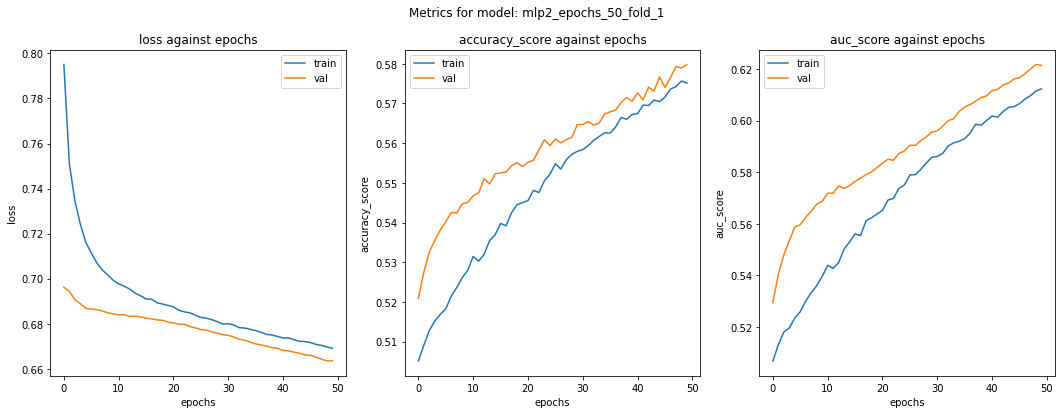

training model fold 2
Epoch 1/50
246/246 [==============================] - 3s 8ms/step - loss: 0.8503 - accuracy: 0.5039 - auc: 0.5047 - val_loss: 0.6957 - val_accuracy: 0.5257 - val_auc: 0.5369
Epoch 2/50
246/246 [==============================] - 2s 6ms/step - loss: 0.7667 - accuracy: 0.5077 - auc: 0.5102 - val_loss: 0.6936 - val_accuracy: 0.5333 - val_auc: 0.5474
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7407 - accuracy: 0.5146 - auc: 0.5198 - val_loss: 0.6907 - val_accuracy: 0.5381 - val_auc: 0.5543
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7299 - accuracy: 0.5134 - auc: 0.5194 - val_loss: 0.6879 - val_accuracy: 0.5409 - val_auc: 0.5605
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7212 - accuracy: 0.5173 - auc: 0.5238 - val_loss: 0.6866 - val_accuracy: 0.5437 - val_auc: 0.5628
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7148 - accuracy: 0.5175 - auc: 0

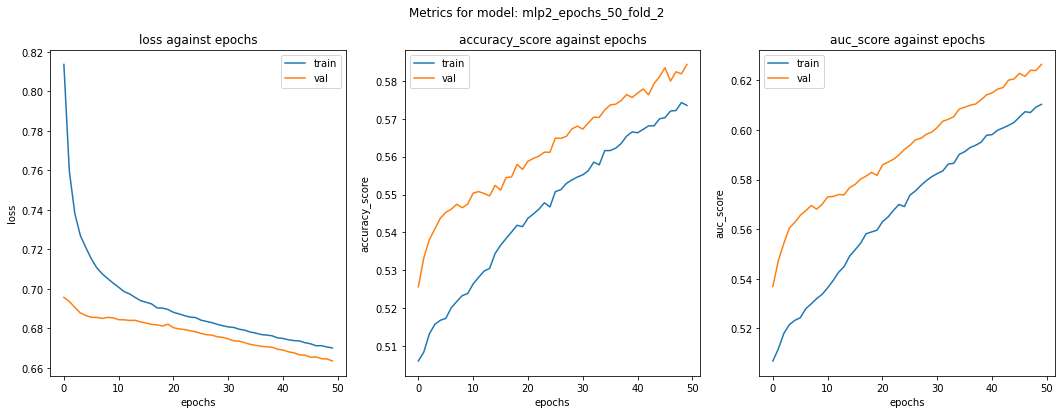

training model fold 3
Epoch 1/50
246/246 [==============================] - 3s 8ms/step - loss: 0.8208 - accuracy: 0.5078 - auc: 0.5088 - val_loss: 0.6975 - val_accuracy: 0.5155 - val_auc: 0.5281
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7548 - accuracy: 0.5110 - auc: 0.5151 - val_loss: 0.6955 - val_accuracy: 0.5251 - val_auc: 0.5359
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7375 - accuracy: 0.5129 - auc: 0.5179 - val_loss: 0.6917 - val_accuracy: 0.5296 - val_auc: 0.5452
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7261 - accuracy: 0.5142 - auc: 0.5212 - val_loss: 0.6893 - val_accuracy: 0.5330 - val_auc: 0.5513
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7189 - accuracy: 0.5187 - auc: 0.5262 - val_loss: 0.6899 - val_accuracy: 0.5340 - val_auc: 0.5523
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7130 - accuracy: 0.5192 - auc: 0

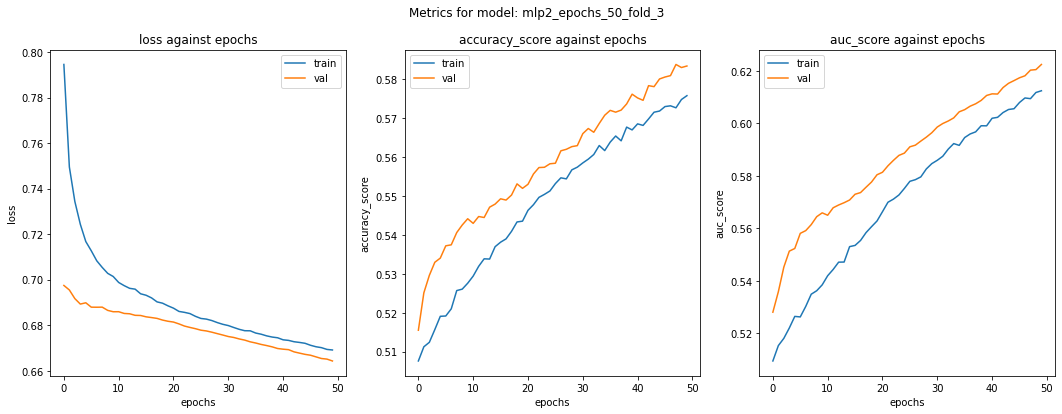

training model fold 4
Epoch 1/50
246/246 [==============================] - 3s 8ms/step - loss: 0.8277 - accuracy: 0.5025 - auc: 0.5049 - val_loss: 0.6977 - val_accuracy: 0.5248 - val_auc: 0.5326
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7554 - accuracy: 0.5096 - auc: 0.5134 - val_loss: 0.6938 - val_accuracy: 0.5304 - val_auc: 0.5422
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7380 - accuracy: 0.5117 - auc: 0.5165 - val_loss: 0.6908 - val_accuracy: 0.5335 - val_auc: 0.5488
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7252 - accuracy: 0.5152 - auc: 0.5211 - val_loss: 0.6889 - val_accuracy: 0.5362 - val_auc: 0.5519
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7182 - accuracy: 0.5177 - auc: 0.5239 - val_loss: 0.6877 - val_accuracy: 0.5360 - val_auc: 0.5546
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7132 - accuracy: 0.5155 - auc: 0

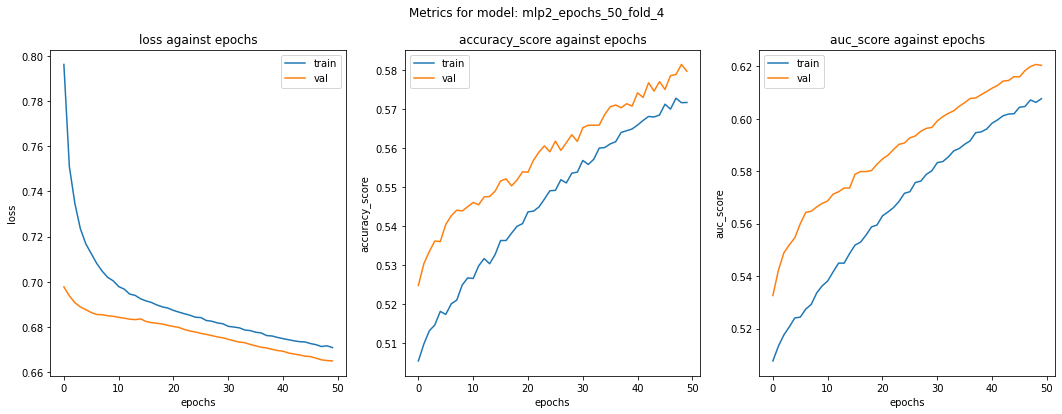

training model fold 5
Epoch 1/50
246/246 [==============================] - 3s 8ms/step - loss: 0.8377 - accuracy: 0.5028 - auc: 0.5042 - val_loss: 0.7010 - val_accuracy: 0.5233 - val_auc: 0.5334
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7615 - accuracy: 0.5090 - auc: 0.5126 - val_loss: 0.6952 - val_accuracy: 0.5281 - val_auc: 0.5401
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7400 - accuracy: 0.5107 - auc: 0.5148 - val_loss: 0.6921 - val_accuracy: 0.5325 - val_auc: 0.5464
Epoch 4/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7270 - accuracy: 0.5133 - auc: 0.5192 - val_loss: 0.6893 - val_accuracy: 0.5357 - val_auc: 0.5526
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7186 - accuracy: 0.5184 - auc: 0.5247 - val_loss: 0.6885 - val_accuracy: 0.5381 - val_auc: 0.5553
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7139 - accuracy: 0.5194 - auc: 0

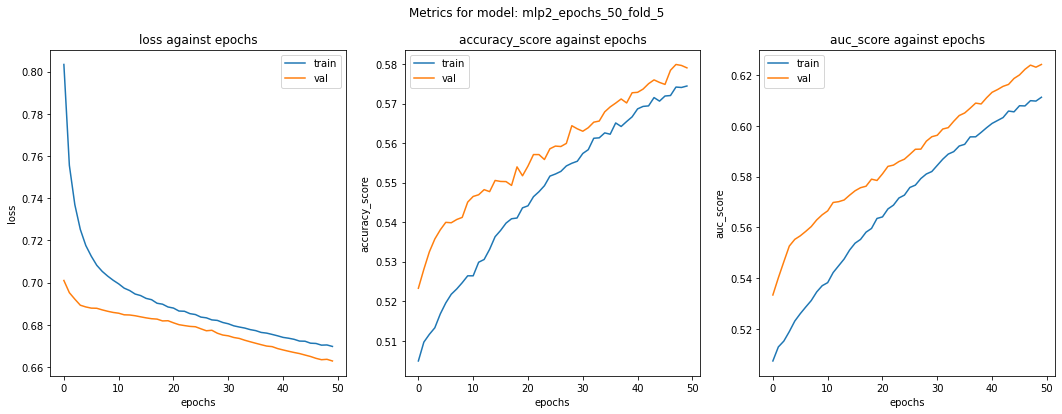

training model fold 6
Epoch 1/50
246/246 [==============================] - 3s 8ms/step - loss: 0.8215 - accuracy: 0.5046 - auc: 0.5069 - val_loss: 0.6962 - val_accuracy: 0.5246 - val_auc: 0.5315
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7508 - accuracy: 0.5120 - auc: 0.5172 - val_loss: 0.6937 - val_accuracy: 0.5258 - val_auc: 0.5409
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7328 - accuracy: 0.5147 - auc: 0.5202 - val_loss: 0.6915 - val_accuracy: 0.5300 - val_auc: 0.5434
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7237 - accuracy: 0.5138 - auc: 0.5193 - val_loss: 0.6892 - val_accuracy: 0.5352 - val_auc: 0.5506
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7178 - accuracy: 0.5137 - auc: 0.5192 - val_loss: 0.6877 - val_accuracy: 0.5391 - val_auc: 0.5531
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7119 - accuracy: 0.5181 - auc: 0

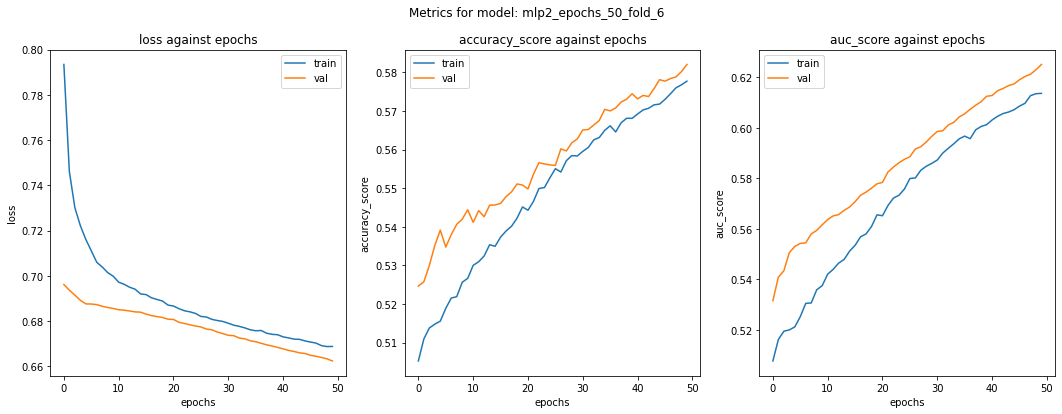

training model fold 7
Epoch 1/50
246/246 [==============================] - 3s 8ms/step - loss: 0.8459 - accuracy: 0.5055 - auc: 0.5084 - val_loss: 0.7052 - val_accuracy: 0.5071 - val_auc: 0.5220
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7661 - accuracy: 0.5093 - auc: 0.5117 - val_loss: 0.6977 - val_accuracy: 0.5152 - val_auc: 0.5344
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7445 - accuracy: 0.5108 - auc: 0.5152 - val_loss: 0.6933 - val_accuracy: 0.5267 - val_auc: 0.5434
Epoch 4/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7310 - accuracy: 0.5155 - auc: 0.5190 - val_loss: 0.6910 - val_accuracy: 0.5300 - val_auc: 0.5461
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7202 - accuracy: 0.5155 - auc: 0.5235 - val_loss: 0.6894 - val_accuracy: 0.5321 - val_auc: 0.5508
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7135 - accuracy: 0.5186 - auc: 0

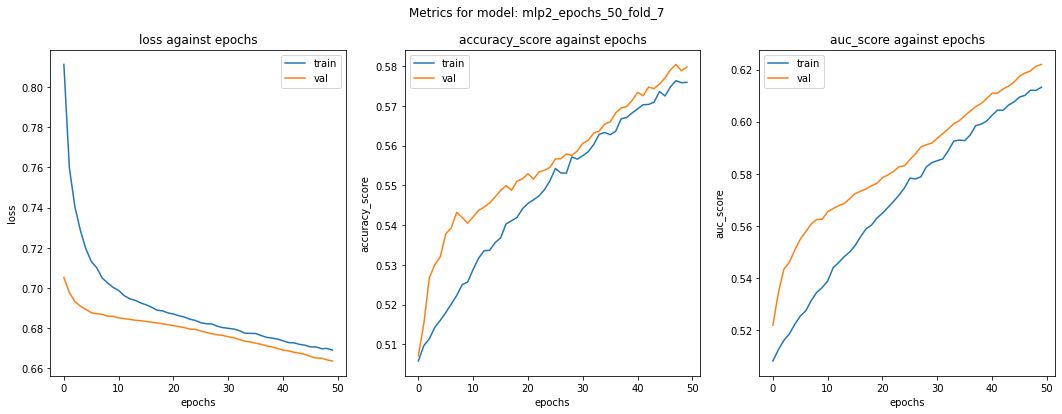

training model fold 8
Epoch 1/50
246/246 [==============================] - 3s 9ms/step - loss: 0.8295 - accuracy: 0.5043 - auc: 0.5046 - val_loss: 0.6966 - val_accuracy: 0.5211 - val_auc: 0.5285
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7580 - accuracy: 0.5076 - auc: 0.5099 - val_loss: 0.6940 - val_accuracy: 0.5253 - val_auc: 0.5382
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7353 - accuracy: 0.5110 - auc: 0.5162 - val_loss: 0.6898 - val_accuracy: 0.5328 - val_auc: 0.5468
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7245 - accuracy: 0.5155 - auc: 0.5209 - val_loss: 0.6881 - val_accuracy: 0.5386 - val_auc: 0.5532
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7165 - accuracy: 0.5174 - auc: 0.5249 - val_loss: 0.6880 - val_accuracy: 0.5400 - val_auc: 0.5548
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7121 - accuracy: 0.5189 - auc: 0

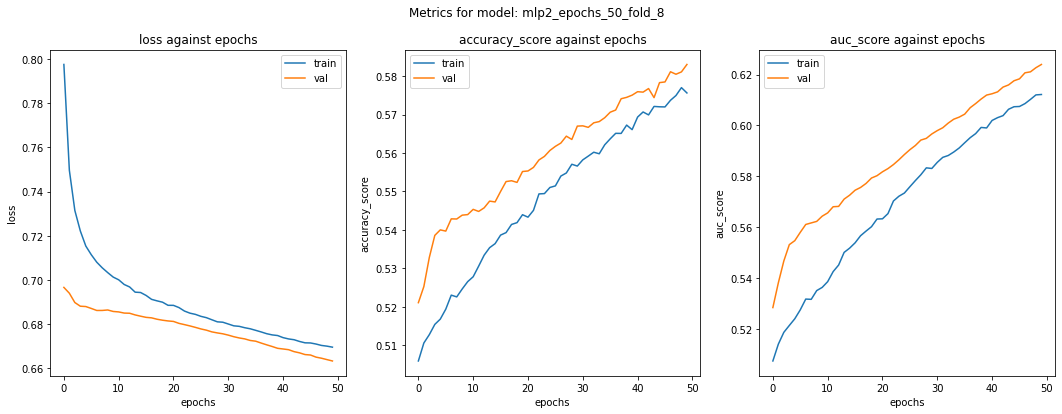

training model fold 9
Epoch 1/50
246/246 [==============================] - 3s 9ms/step - loss: 0.8284 - accuracy: 0.5036 - auc: 0.5055 - val_loss: 0.7039 - val_accuracy: 0.5050 - val_auc: 0.5204
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7579 - accuracy: 0.5082 - auc: 0.5115 - val_loss: 0.6968 - val_accuracy: 0.5173 - val_auc: 0.5302
Epoch 3/50
246/246 [==============================] - 2s 9ms/step - loss: 0.7381 - accuracy: 0.5121 - auc: 0.5165 - val_loss: 0.6928 - val_accuracy: 0.5263 - val_auc: 0.5404
Epoch 4/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7262 - accuracy: 0.5145 - auc: 0.5202 - val_loss: 0.6904 - val_accuracy: 0.5307 - val_auc: 0.5476
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7185 - accuracy: 0.5172 - auc: 0.5230 - val_loss: 0.6884 - val_accuracy: 0.5360 - val_auc: 0.5530
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7119 - accuracy: 0.5193 - auc: 0

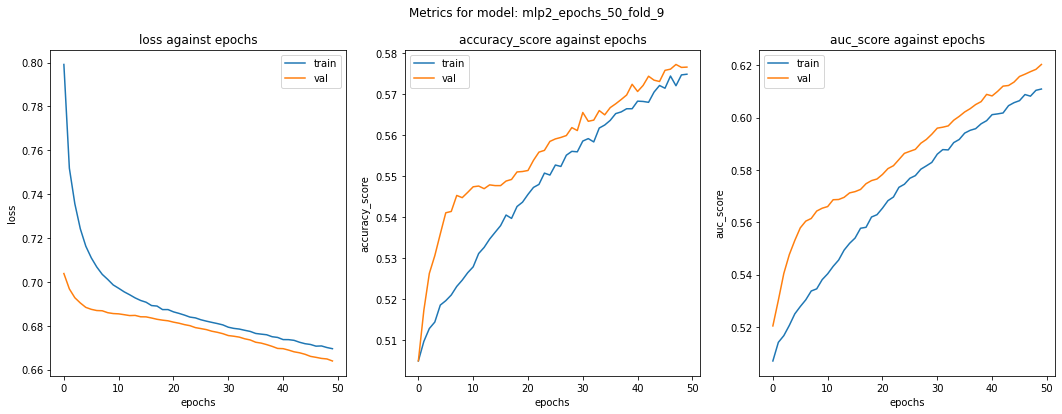

training model fold 10
Epoch 1/50
246/246 [==============================] - 3s 9ms/step - loss: 0.8162 - accuracy: 0.5069 - auc: 0.5071 - val_loss: 0.6943 - val_accuracy: 0.5253 - val_auc: 0.5355
Epoch 2/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7544 - accuracy: 0.5084 - auc: 0.5116 - val_loss: 0.6929 - val_accuracy: 0.5304 - val_auc: 0.5444
Epoch 3/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7354 - accuracy: 0.5124 - auc: 0.5175 - val_loss: 0.6895 - val_accuracy: 0.5364 - val_auc: 0.5519
Epoch 4/50
246/246 [==============================] - 2s 8ms/step - loss: 0.7228 - accuracy: 0.5168 - auc: 0.5229 - val_loss: 0.6882 - val_accuracy: 0.5365 - val_auc: 0.5566
Epoch 5/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7168 - accuracy: 0.5164 - auc: 0.5226 - val_loss: 0.6870 - val_accuracy: 0.5397 - val_auc: 0.5604
Epoch 6/50
246/246 [==============================] - 2s 7ms/step - loss: 0.7091 - accuracy: 0.5216 - auc: 

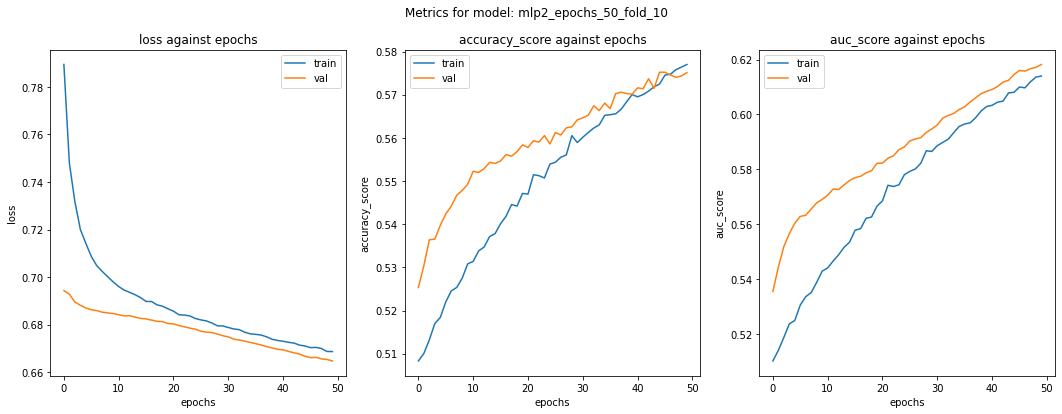

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [867.9164212270582, 0.5802936317938271, 0.5797114618059954, 8646.9, 7562.5, 6117.7, 5606.0]
saved model metrics

model_name:  mlp2_epochs_100
model_params:  batch_size=1024, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7fd243ec2200>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=100
training model fold 1
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8434 - accuracy: 0.5065 - auc: 0.5080 - val_loss: 0.7054 - val_accuracy: 0.5112 - val_auc: 0.5318
Epoch 2/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7703 - accuracy: 0.5074 - auc: 0.5108 - val_loss: 0.6978 - val_accuracy: 0.5263 - val_auc: 0.5409
Epoch 3/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7448 - accuracy: 0.5117 - auc: 0.5168 - val_loss: 0.6924 - val_accuracy: 0.5314 - val_auc: 0.5472
Epoch 4/100
246/246 [

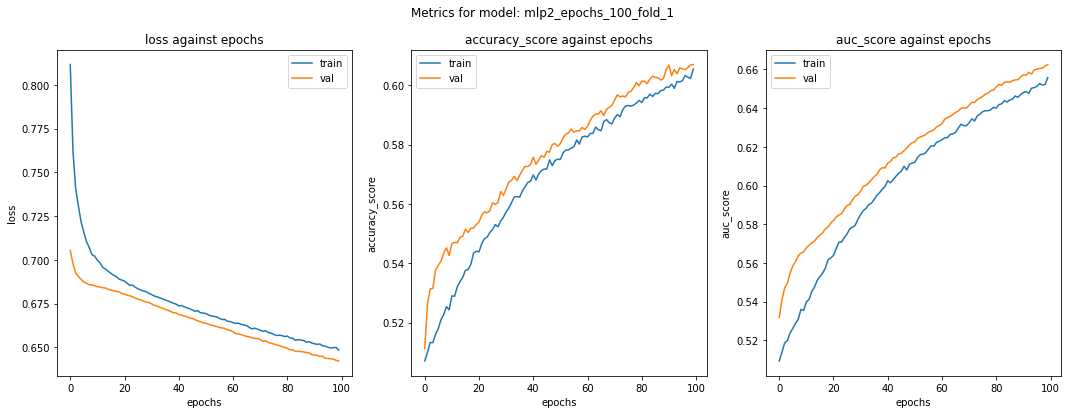

training model fold 2
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8430 - accuracy: 0.5037 - auc: 0.5047 - val_loss: 0.7072 - val_accuracy: 0.5188 - val_auc: 0.5351
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7630 - accuracy: 0.5099 - auc: 0.5153 - val_loss: 0.6980 - val_accuracy: 0.5333 - val_auc: 0.5443
Epoch 3/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7419 - accuracy: 0.5115 - auc: 0.5165 - val_loss: 0.6932 - val_accuracy: 0.5365 - val_auc: 0.5527
Epoch 4/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7294 - accuracy: 0.5144 - auc: 0.5199 - val_loss: 0.6902 - val_accuracy: 0.5394 - val_auc: 0.5559
Epoch 5/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7209 - accuracy: 0.5155 - auc: 0.5215 - val_loss: 0.6880 - val_accuracy: 0.5406 - val_auc: 0.5607
Epoch 6/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7148 - accuracy: 0.5176 - 

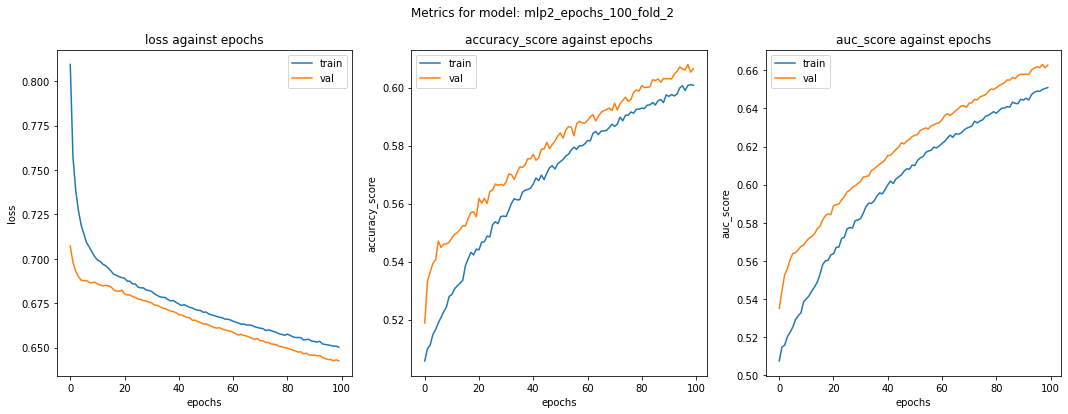

training model fold 3
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8321 - accuracy: 0.5027 - auc: 0.5035 - val_loss: 0.7045 - val_accuracy: 0.5116 - val_auc: 0.5293
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7603 - accuracy: 0.5077 - auc: 0.5115 - val_loss: 0.6962 - val_accuracy: 0.5241 - val_auc: 0.5381
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7394 - accuracy: 0.5100 - auc: 0.5144 - val_loss: 0.6925 - val_accuracy: 0.5304 - val_auc: 0.5437
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7257 - accuracy: 0.5156 - auc: 0.5216 - val_loss: 0.6906 - val_accuracy: 0.5318 - val_auc: 0.5485
Epoch 5/100
246/246 [==============================] - 2s 9ms/step - loss: 0.7210 - accuracy: 0.5151 - auc: 0.5212 - val_loss: 0.6900 - val_accuracy: 0.5329 - val_auc: 0.5489
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7147 - accuracy: 0.5165 - 

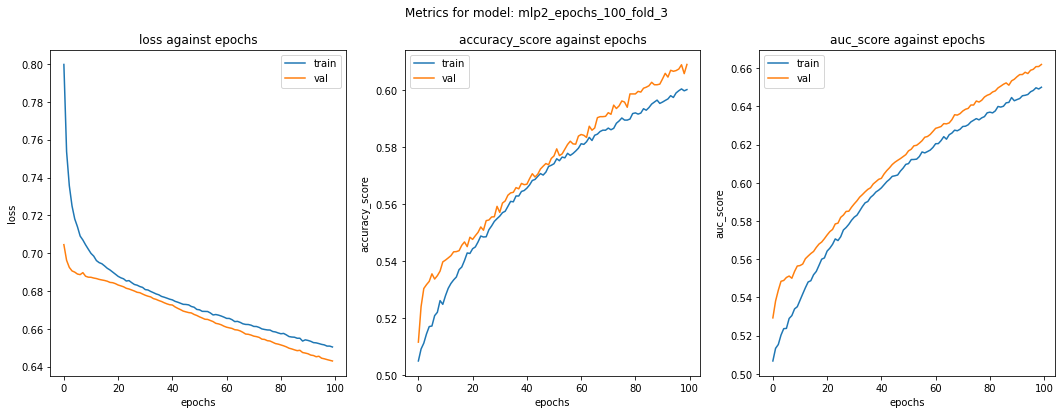

training model fold 4
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8359 - accuracy: 0.5027 - auc: 0.5043 - val_loss: 0.6968 - val_accuracy: 0.5225 - val_auc: 0.5341
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7561 - accuracy: 0.5105 - auc: 0.5156 - val_loss: 0.6939 - val_accuracy: 0.5295 - val_auc: 0.5450
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7374 - accuracy: 0.5131 - auc: 0.5182 - val_loss: 0.6895 - val_accuracy: 0.5365 - val_auc: 0.5543
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7274 - accuracy: 0.5105 - auc: 0.5160 - val_loss: 0.6878 - val_accuracy: 0.5420 - val_auc: 0.5598
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7178 - accuracy: 0.5143 - auc: 0.5222 - val_loss: 0.6867 - val_accuracy: 0.5438 - val_auc: 0.5623
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7129 - accuracy: 0.5177 - 

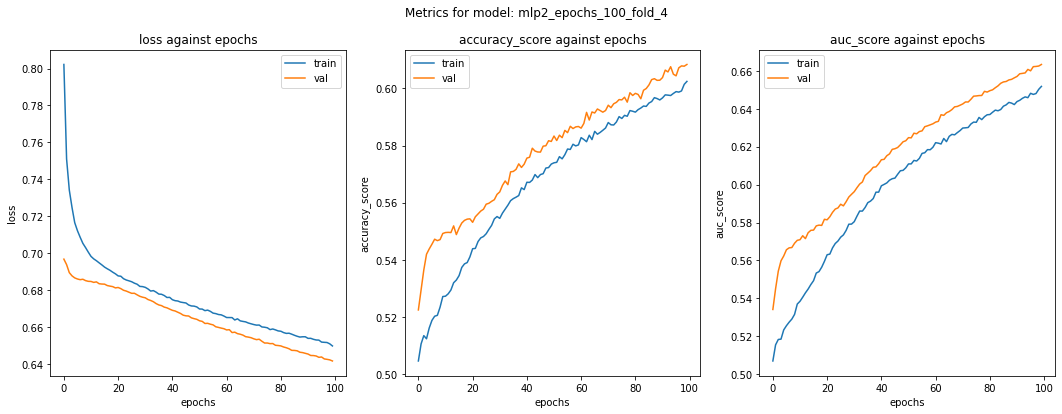

training model fold 5
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8224 - accuracy: 0.5058 - auc: 0.5076 - val_loss: 0.7052 - val_accuracy: 0.5123 - val_auc: 0.5307
Epoch 2/100
246/246 [==============================] - 2s 7ms/step - loss: 0.7571 - accuracy: 0.5096 - auc: 0.5136 - val_loss: 0.6962 - val_accuracy: 0.5271 - val_auc: 0.5428
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7371 - accuracy: 0.5116 - auc: 0.5163 - val_loss: 0.6934 - val_accuracy: 0.5291 - val_auc: 0.5464
Epoch 4/100
246/246 [==============================] - 2s 9ms/step - loss: 0.7270 - accuracy: 0.5125 - auc: 0.5173 - val_loss: 0.6914 - val_accuracy: 0.5325 - val_auc: 0.5502
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7179 - accuracy: 0.5153 - auc: 0.5216 - val_loss: 0.6892 - val_accuracy: 0.5356 - val_auc: 0.5531
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7132 - accuracy: 0.5181 - 

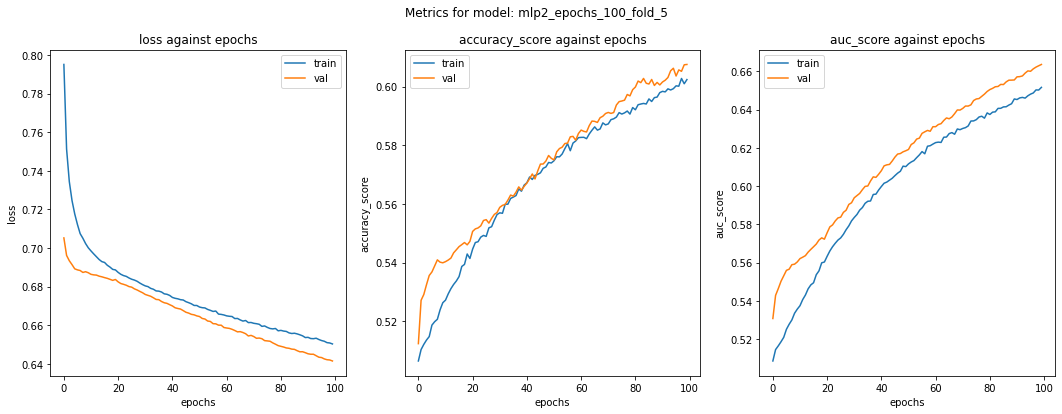

training model fold 6
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8202 - accuracy: 0.5035 - auc: 0.5064 - val_loss: 0.6965 - val_accuracy: 0.5183 - val_auc: 0.5256
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7563 - accuracy: 0.5091 - auc: 0.5113 - val_loss: 0.6941 - val_accuracy: 0.5266 - val_auc: 0.5376
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7352 - accuracy: 0.5123 - auc: 0.5178 - val_loss: 0.6907 - val_accuracy: 0.5338 - val_auc: 0.5455
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7250 - accuracy: 0.5128 - auc: 0.5197 - val_loss: 0.6891 - val_accuracy: 0.5351 - val_auc: 0.5508
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7167 - accuracy: 0.5186 - auc: 0.5255 - val_loss: 0.6890 - val_accuracy: 0.5322 - val_auc: 0.5500
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7117 - accuracy: 0.5189 - 

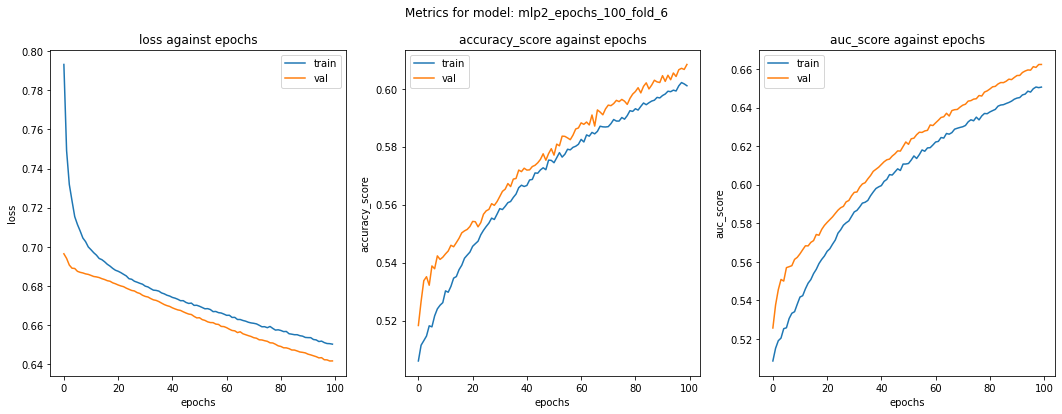

training model fold 7
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8350 - accuracy: 0.5040 - auc: 0.5045 - val_loss: 0.7021 - val_accuracy: 0.5088 - val_auc: 0.5238
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7606 - accuracy: 0.5083 - auc: 0.5119 - val_loss: 0.6956 - val_accuracy: 0.5209 - val_auc: 0.5368
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7410 - accuracy: 0.5117 - auc: 0.5162 - val_loss: 0.6919 - val_accuracy: 0.5287 - val_auc: 0.5414
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7269 - accuracy: 0.5142 - auc: 0.5201 - val_loss: 0.6902 - val_accuracy: 0.5309 - val_auc: 0.5455
Epoch 5/100
246/246 [==============================] - 2s 9ms/step - loss: 0.7199 - accuracy: 0.5166 - auc: 0.5234 - val_loss: 0.6886 - val_accuracy: 0.5323 - val_auc: 0.5498
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7129 - accuracy: 0.5186 - 

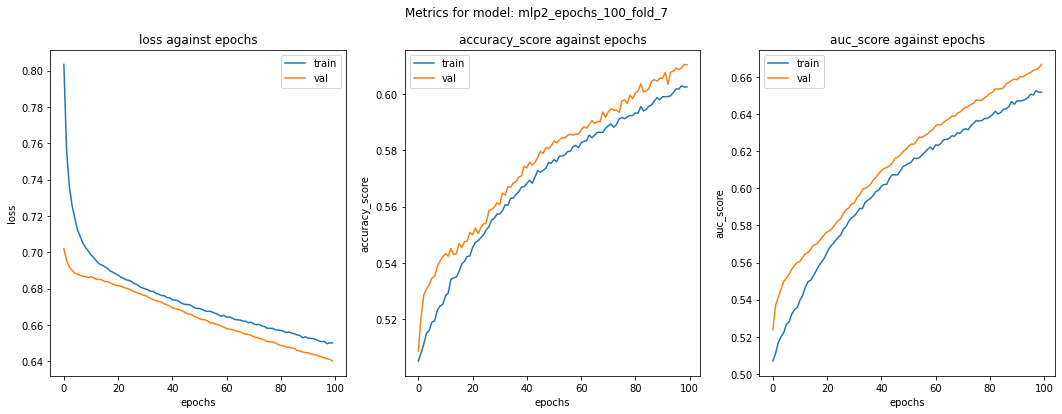

training model fold 8
Epoch 1/100
246/246 [==============================] - 4s 10ms/step - loss: 0.8442 - accuracy: 0.5058 - auc: 0.5062 - val_loss: 0.6979 - val_accuracy: 0.5190 - val_auc: 0.5313
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7619 - accuracy: 0.5097 - auc: 0.5136 - val_loss: 0.6944 - val_accuracy: 0.5272 - val_auc: 0.5415
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7417 - accuracy: 0.5125 - auc: 0.5171 - val_loss: 0.6910 - val_accuracy: 0.5334 - val_auc: 0.5502
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7273 - accuracy: 0.5167 - auc: 0.5242 - val_loss: 0.6895 - val_accuracy: 0.5383 - val_auc: 0.5554
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7208 - accuracy: 0.5168 - auc: 0.5230 - val_loss: 0.6870 - val_accuracy: 0.5397 - val_auc: 0.5593
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7155 - accuracy: 0.5186 -

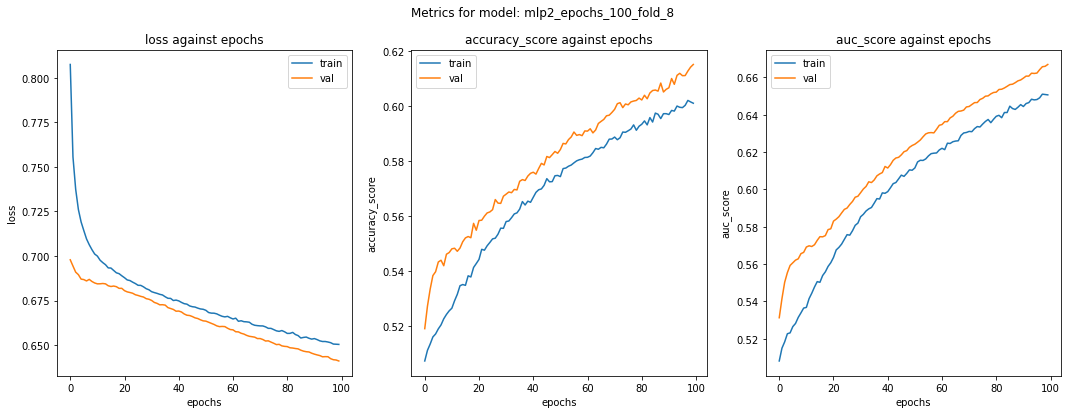

training model fold 9
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8308 - accuracy: 0.5021 - auc: 0.5035 - val_loss: 0.6972 - val_accuracy: 0.5226 - val_auc: 0.5333
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7562 - accuracy: 0.5106 - auc: 0.5145 - val_loss: 0.6954 - val_accuracy: 0.5295 - val_auc: 0.5410
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7365 - accuracy: 0.5139 - auc: 0.5165 - val_loss: 0.6925 - val_accuracy: 0.5301 - val_auc: 0.5464
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7244 - accuracy: 0.5155 - auc: 0.5218 - val_loss: 0.6904 - val_accuracy: 0.5351 - val_auc: 0.5508
Epoch 5/100
246/246 [==============================] - 2s 9ms/step - loss: 0.7192 - accuracy: 0.5168 - auc: 0.5213 - val_loss: 0.6887 - val_accuracy: 0.5373 - val_auc: 0.5549
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7117 - accuracy: 0.5208 - 

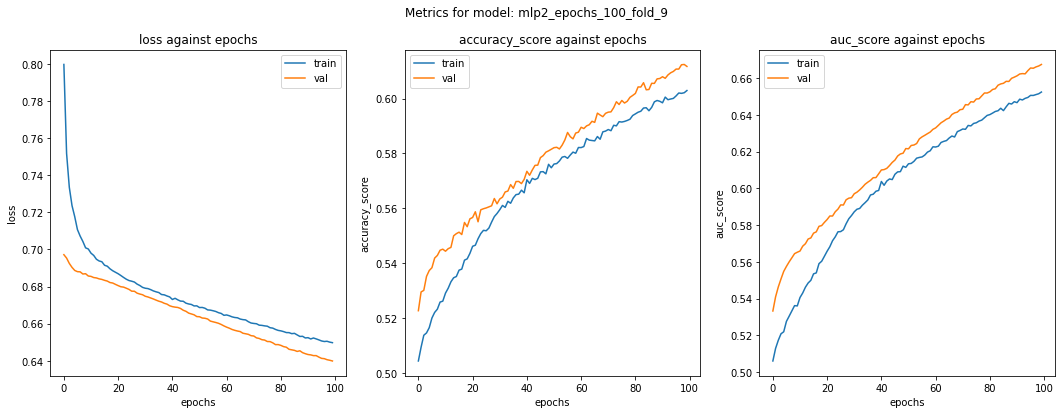

training model fold 10
Epoch 1/100
246/246 [==============================] - 4s 9ms/step - loss: 0.8135 - accuracy: 0.5050 - auc: 0.5064 - val_loss: 0.6943 - val_accuracy: 0.5228 - val_auc: 0.5332
Epoch 2/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7473 - accuracy: 0.5106 - auc: 0.5154 - val_loss: 0.6932 - val_accuracy: 0.5269 - val_auc: 0.5384
Epoch 3/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7329 - accuracy: 0.5103 - auc: 0.5143 - val_loss: 0.6906 - val_accuracy: 0.5296 - val_auc: 0.5448
Epoch 4/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7221 - accuracy: 0.5164 - auc: 0.5201 - val_loss: 0.6899 - val_accuracy: 0.5328 - val_auc: 0.5475
Epoch 5/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7146 - accuracy: 0.5166 - auc: 0.5235 - val_loss: 0.6891 - val_accuracy: 0.5343 - val_auc: 0.5495
Epoch 6/100
246/246 [==============================] - 2s 8ms/step - loss: 0.7111 - accuracy: 0.5188 -

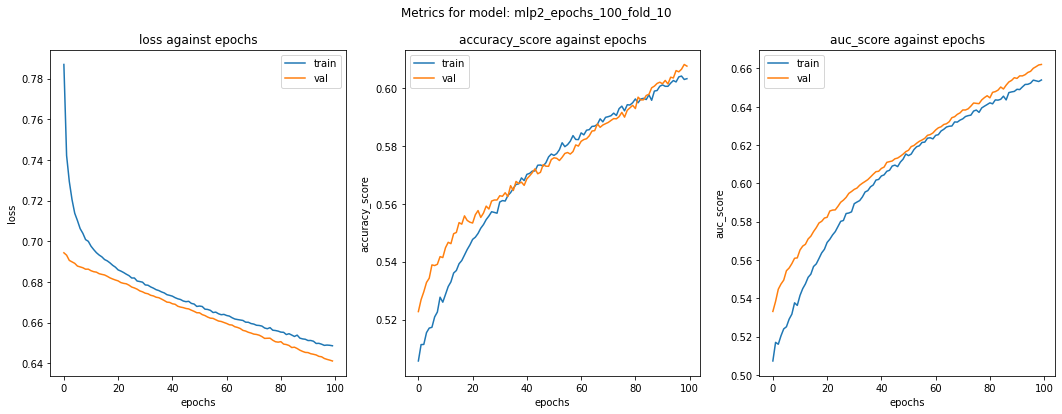

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1205.3725415554352, 0.6091840938180043, 0.6087152489929288, 9022.3, 7994.1, 5686.1, 5230.6]
saved model metrics

model_name:  mlp2_epochs_400
model_params:  batch_size=1024, hidden_unit=[100, 200, 400, 200], activation=<function relu at 0x7fd243ec2200>, dropout_rate=[0.2, 0.2, 0.2, 0.2, 0.2], learning_rate=0.0001, epoch=400
training model fold 1
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8194 - accuracy: 0.5048 - auc: 0.5061 - val_loss: 0.6953 - val_accuracy: 0.5169 - val_auc: 0.5259
Epoch 2/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7506 - accuracy: 0.5070 - auc: 0.5105 - val_loss: 0.6931 - val_accuracy: 0.5265 - val_auc: 0.5399
Epoch 3/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7313 - accuracy: 0.5127 - auc: 0.5177 - val_loss: 0.6899 - val_accuracy: 0.5330 - val_auc: 0.5477
Epoch 4/400
246/246

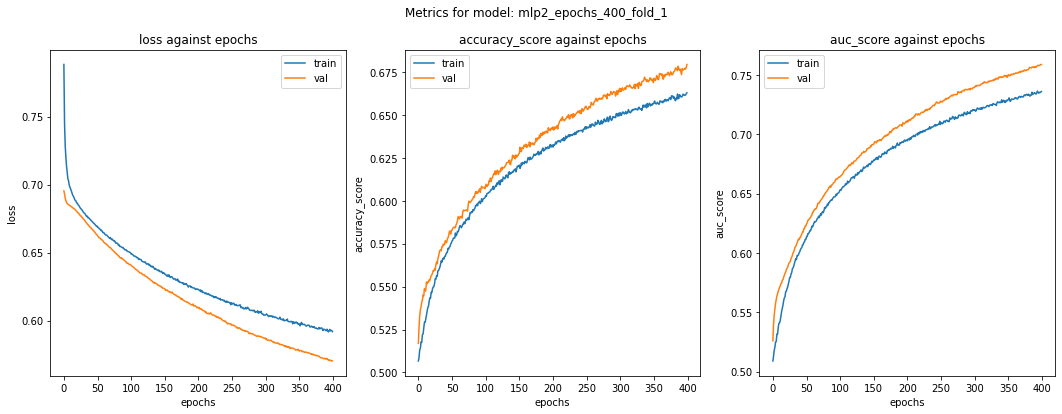

training model fold 2
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8212 - accuracy: 0.5027 - auc: 0.5040 - val_loss: 0.6973 - val_accuracy: 0.5199 - val_auc: 0.5265
Epoch 2/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7520 - accuracy: 0.5106 - auc: 0.5144 - val_loss: 0.6957 - val_accuracy: 0.5264 - val_auc: 0.5384
Epoch 3/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7351 - accuracy: 0.5133 - auc: 0.5178 - val_loss: 0.6926 - val_accuracy: 0.5338 - val_auc: 0.5469
Epoch 4/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7229 - accuracy: 0.5167 - auc: 0.5221 - val_loss: 0.6898 - val_accuracy: 0.5382 - val_auc: 0.5520
Epoch 5/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7162 - accuracy: 0.5162 - auc: 0.5235 - val_loss: 0.6882 - val_accuracy: 0.5378 - val_auc: 0.5563
Epoch 6/400
246/246 [==============================] - 2s 8ms/step - loss: 0.7107 - accuracy: 0.5204 -

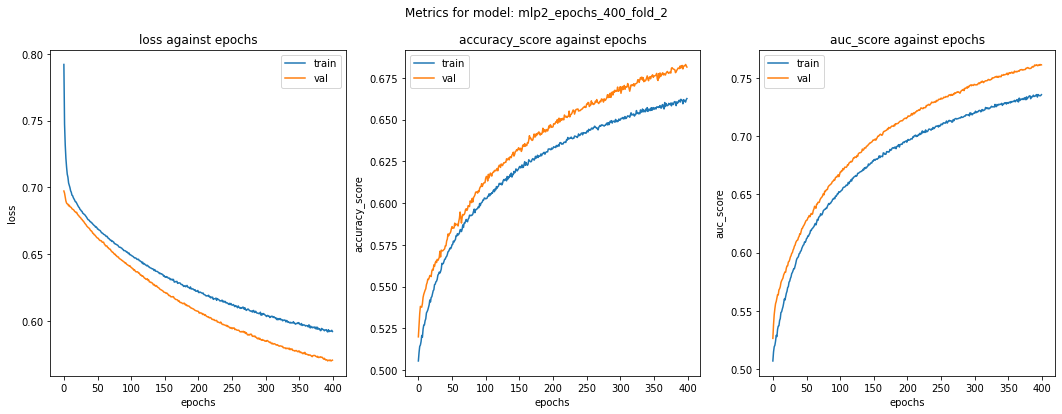

training model fold 3
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8344 - accuracy: 0.5050 - auc: 0.5055 - val_loss: 0.6961 - val_accuracy: 0.5231 - val_auc: 0.5351
Epoch 2/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7601 - accuracy: 0.5093 - auc: 0.5141 - val_loss: 0.6944 - val_accuracy: 0.5293 - val_auc: 0.5433
Epoch 3/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7405 - accuracy: 0.5112 - auc: 0.5168 - val_loss: 0.6910 - val_accuracy: 0.5342 - val_auc: 0.5502
Epoch 4/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7290 - accuracy: 0.5150 - auc: 0.5207 - val_loss: 0.6892 - val_accuracy: 0.5365 - val_auc: 0.5546
Epoch 5/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7198 - accuracy: 0.5152 - auc: 0.5228 - val_loss: 0.6890 - val_accuracy: 0.5384 - val_auc: 0.5564
Epoch 6/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7140 - accuracy: 0.5194

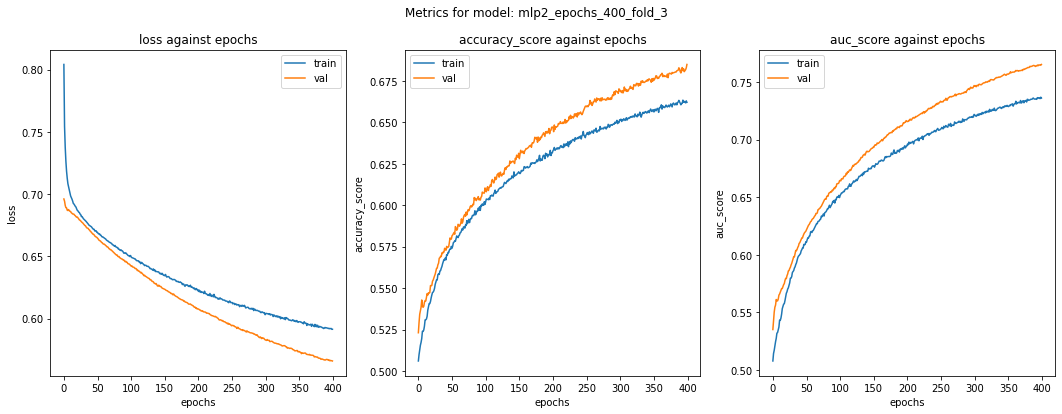

training model fold 4
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8233 - accuracy: 0.5036 - auc: 0.5046 - val_loss: 0.6948 - val_accuracy: 0.5163 - val_auc: 0.5303
Epoch 2/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7527 - accuracy: 0.5104 - auc: 0.5142 - val_loss: 0.6931 - val_accuracy: 0.5297 - val_auc: 0.5417
Epoch 3/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7356 - accuracy: 0.5131 - auc: 0.5184 - val_loss: 0.6894 - val_accuracy: 0.5322 - val_auc: 0.5502
Epoch 4/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7242 - accuracy: 0.5154 - auc: 0.5214 - val_loss: 0.6877 - val_accuracy: 0.5376 - val_auc: 0.5558
Epoch 5/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7174 - accuracy: 0.5174 - auc: 0.5247 - val_loss: 0.6873 - val_accuracy: 0.5399 - val_auc: 0.5582
Epoch 6/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7129 - accuracy: 0.5183 -

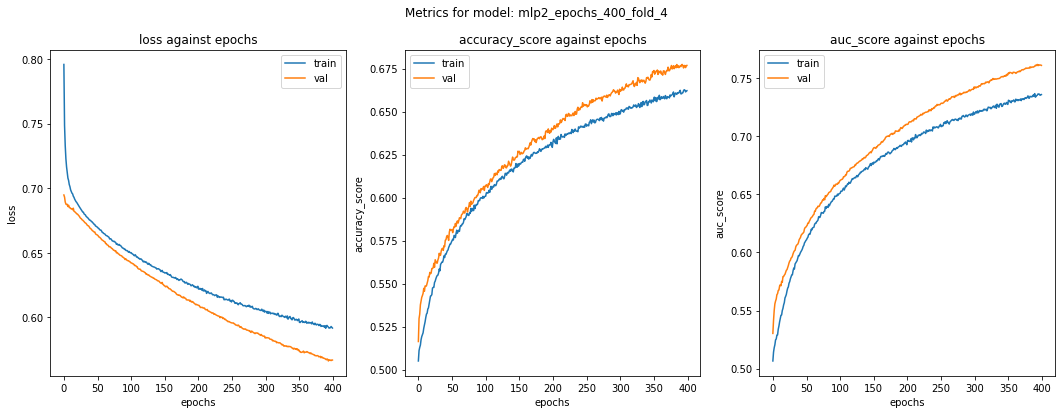

training model fold 5
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8325 - accuracy: 0.5017 - auc: 0.5031 - val_loss: 0.7011 - val_accuracy: 0.5120 - val_auc: 0.5286
Epoch 2/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7605 - accuracy: 0.5069 - auc: 0.5104 - val_loss: 0.6955 - val_accuracy: 0.5248 - val_auc: 0.5355
Epoch 3/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7391 - accuracy: 0.5108 - auc: 0.5147 - val_loss: 0.6927 - val_accuracy: 0.5283 - val_auc: 0.5438
Epoch 4/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7264 - accuracy: 0.5165 - auc: 0.5219 - val_loss: 0.6896 - val_accuracy: 0.5343 - val_auc: 0.5514
Epoch 5/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7194 - accuracy: 0.5156 - auc: 0.5224 - val_loss: 0.6881 - val_accuracy: 0.5372 - val_auc: 0.5556
Epoch 6/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7133 - accuracy: 0.5203 

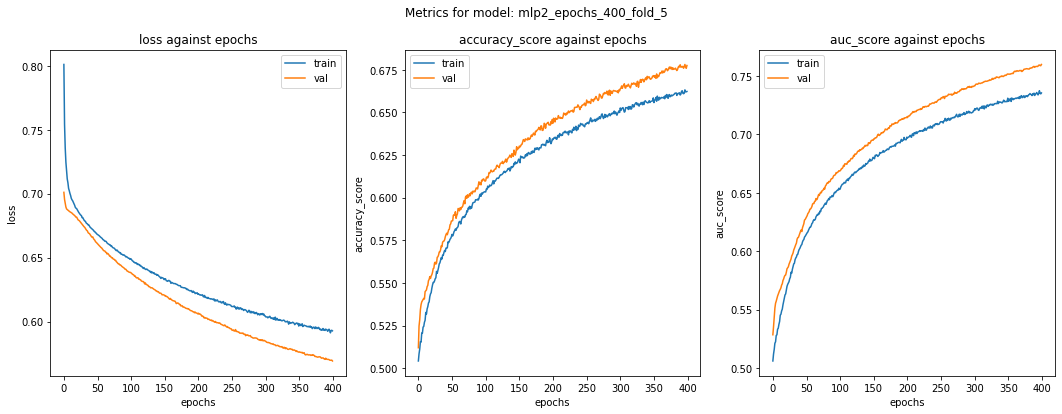

training model fold 6
Epoch 1/400
246/246 [==============================] - 4s 10ms/step - loss: 0.8201 - accuracy: 0.5050 - auc: 0.5066 - val_loss: 0.6972 - val_accuracy: 0.5146 - val_auc: 0.5260
Epoch 2/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7522 - accuracy: 0.5095 - auc: 0.5134 - val_loss: 0.6944 - val_accuracy: 0.5286 - val_auc: 0.5415
Epoch 3/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7343 - accuracy: 0.5120 - auc: 0.5176 - val_loss: 0.6915 - val_accuracy: 0.5317 - val_auc: 0.5452
Epoch 4/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7233 - accuracy: 0.5159 - auc: 0.5216 - val_loss: 0.6894 - val_accuracy: 0.5337 - val_auc: 0.5491
Epoch 5/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7160 - accuracy: 0.5162 - auc: 0.5248 - val_loss: 0.6884 - val_accuracy: 0.5356 - val_auc: 0.5528
Epoch 6/400
246/246 [==============================] - 2s 9ms/step - loss: 0.7118 - accuracy: 0.5189 -

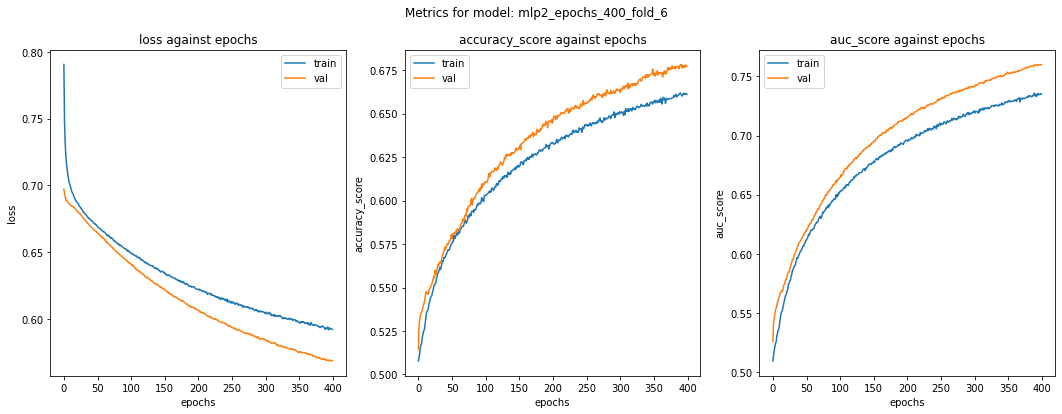

training model fold 7
Epoch 1/400
246/246 [==============================] - 4s 11ms/step - loss: 0.8242 - accuracy: 0.5037 - auc: 0.5038 - val_loss: 0.7006 - val_accuracy: 0.5163 - val_auc: 0.5255
Epoch 2/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7555 - accuracy: 0.5089 - auc: 0.5115 - val_loss: 0.6967 - val_accuracy: 0.5278 - val_auc: 0.5380
Epoch 3/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7348 - accuracy: 0.5137 - auc: 0.5185 - val_loss: 0.6920 - val_accuracy: 0.5311 - val_auc: 0.5461
Epoch 4/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7235 - accuracy: 0.5143 - auc: 0.5206 - val_loss: 0.6900 - val_accuracy: 0.5340 - val_auc: 0.5492
Epoch 5/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7174 - accuracy: 0.5193 - auc: 0.5243 - val_loss: 0.6880 - val_accuracy: 0.5355 - val_auc: 0.5546
Epoch 6/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7122 - accuracy: 0.5

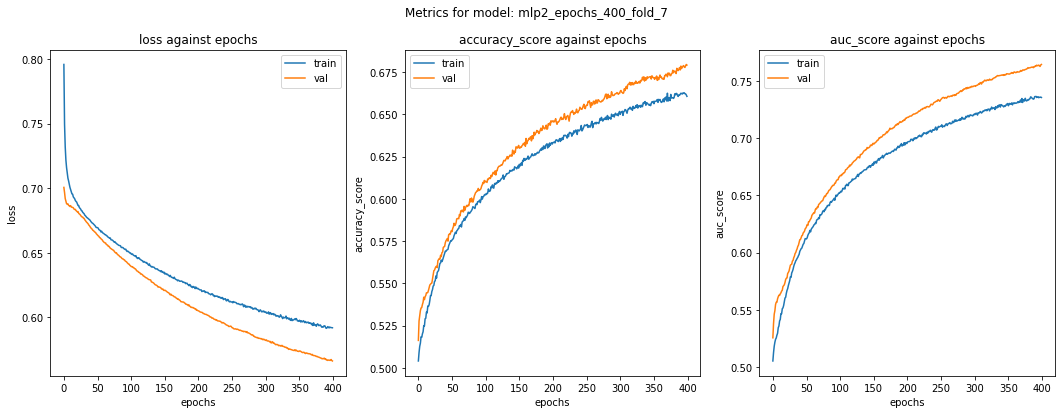

training model fold 8
Epoch 1/400
246/246 [==============================] - 4s 11ms/step - loss: 0.8344 - accuracy: 0.5039 - auc: 0.5044 - val_loss: 0.6975 - val_accuracy: 0.5163 - val_auc: 0.5263
Epoch 2/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7611 - accuracy: 0.5123 - auc: 0.5147 - val_loss: 0.6955 - val_accuracy: 0.5257 - val_auc: 0.5380
Epoch 3/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7410 - accuracy: 0.5134 - auc: 0.5174 - val_loss: 0.6909 - val_accuracy: 0.5324 - val_auc: 0.5477
Epoch 4/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7281 - accuracy: 0.5146 - auc: 0.5220 - val_loss: 0.6895 - val_accuracy: 0.5350 - val_auc: 0.5522
Epoch 5/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7201 - accuracy: 0.5179 - auc: 0.5244 - val_loss: 0.6884 - val_accuracy: 0.5355 - val_auc: 0.5554
Epoch 6/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7145 - accuracy: 0.5

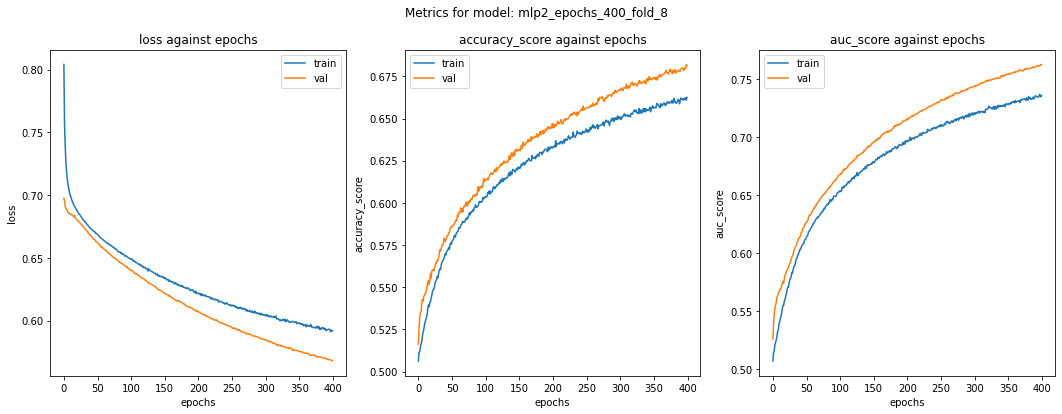

training model fold 9
Epoch 1/400
246/246 [==============================] - 4s 11ms/step - loss: 0.8374 - accuracy: 0.5015 - auc: 0.5036 - val_loss: 0.6981 - val_accuracy: 0.5105 - val_auc: 0.5231
Epoch 2/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7628 - accuracy: 0.5087 - auc: 0.5108 - val_loss: 0.6953 - val_accuracy: 0.5224 - val_auc: 0.5363
Epoch 3/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7403 - accuracy: 0.5115 - auc: 0.5163 - val_loss: 0.6922 - val_accuracy: 0.5287 - val_auc: 0.5442
Epoch 4/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7266 - accuracy: 0.5154 - auc: 0.5202 - val_loss: 0.6895 - val_accuracy: 0.5339 - val_auc: 0.5515
Epoch 5/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7188 - accuracy: 0.5174 - auc: 0.5245 - val_loss: 0.6880 - val_accuracy: 0.5371 - val_auc: 0.5556
Epoch 6/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7135 - accuracy: 0.5

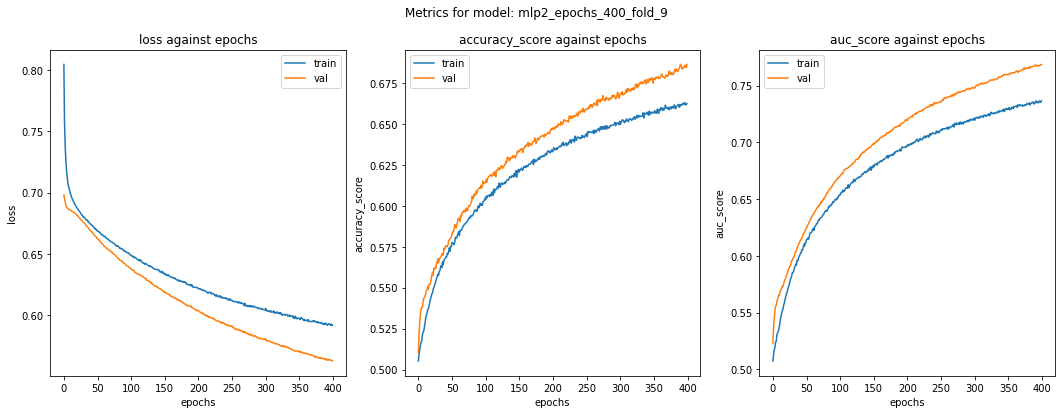

training model fold 10
Epoch 1/400
246/246 [==============================] - 4s 11ms/step - loss: 0.8308 - accuracy: 0.5043 - auc: 0.5057 - val_loss: 0.6980 - val_accuracy: 0.5266 - val_auc: 0.5341
Epoch 2/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7579 - accuracy: 0.5088 - auc: 0.5118 - val_loss: 0.6938 - val_accuracy: 0.5365 - val_auc: 0.5454
Epoch 3/400
246/246 [==============================] - 2s 10ms/step - loss: 0.7358 - accuracy: 0.5132 - auc: 0.5179 - val_loss: 0.6905 - val_accuracy: 0.5390 - val_auc: 0.5505
Epoch 4/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7269 - accuracy: 0.5125 - auc: 0.5179 - val_loss: 0.6902 - val_accuracy: 0.5392 - val_auc: 0.5530
Epoch 5/400
246/246 [==============================] - 3s 11ms/step - loss: 0.7182 - accuracy: 0.5173 - auc: 0.5249 - val_loss: 0.6884 - val_accuracy: 0.5419 - val_auc: 0.5571
Epoch 6/400
246/246 [==============================] - 3s 10ms/step - loss: 0.7130 - accuracy: 0.

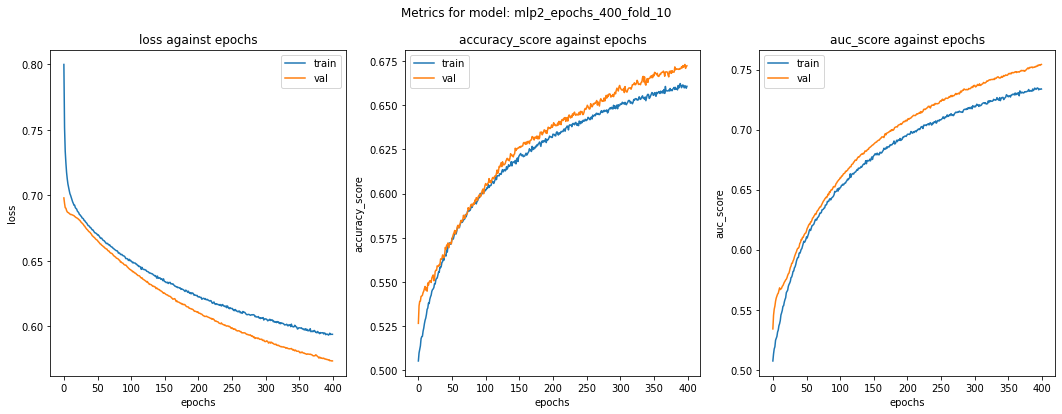

cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg
cv_scores_ave:  [1997.4421658358701, 0.6796345561775483, 0.6793919893424645, 9862.2, 9122.1, 4558.1, 4390.7]
saved model metrics


In [ ]:
for batch_size in batch_sizes:
  for hidden_unit in hidden_units:
    for activation in activations:
      for dropout_rate in dropout_rates:
        for learning_rate in learning_rates:
          for epoch in epochs:

            output_filename = "CV_SCORES_AVE_NNDL.csv"
            workbook_name = "12A_nndl_cv_mlp2_epochs"
            model_name = f"mlp2_epochs_{epoch}"
            model_params = f"batch_size={batch_size}, hidden_unit={hidden_unit}, activation={activation}, dropout_rate={dropout_rate}, learning_rate={learning_rate}, epoch={epoch}"
                    
            print("")
            print("model_name: ", model_name)
            print("model_params: ", model_params)

            # cross validation
            cv_scores = []

            for i, (train_idx, val_idx) in enumerate(kf.split(x_train)):
              # train-val data (for utility score calculation) 
              train_cv, val_cv = train.iloc[train_idx], train.iloc[val_idx]
              # train-val features 
              x_train_cv, x_val_cv, y_train_cv, y_val_cv = x_train[train_idx], x_train[val_idx], y_train[train_idx], y_train[val_idx]

              # scaling data to make it easier for models to train
              scaler = StandardScaler().fit(x_train_cv)
              x_train_cv = scaler.transform(x_train_cv)

              # test set scaled on the same scaler as train, because models are fitted on the train distributions and not test distributions
              x_val_cv = scaler.transform(x_val_cv)

              print(f"training model fold {i+1}")

              model = create_mlp(x_train_cv.shape[1], hidden_unit, activation, dropout_rate, learning_rate)
              model_name_fold = model_name + f"_fold_{i+1}"
              # CheckpointCallback = ModelCheckpoint(str(PATH_CHECKPOINTS / (model_name + '.hdf5')), monitor='val_loss', verbose=1, save_weights_only=True, save_best_only=True, mode='auto', save_freq='epoch')

              history = model.fit(
                  x_train_cv, 
                  y_train_cv, 
                  epochs=epoch, 
                  batch_size=batch_size,
                  validation_data=(x_val_cv, y_val_cv),
                  # callbacks = [CheckpointCallback]
              )

              model_score = model_scores(model, test=val_cv, x_test=x_val_cv, y_test=y_val_cv)
              cv_scores.append(model_score)

              history_saver(history, model_name_fold, PATH_HISTORIES, already_npy=False)
              history = history_loader(model_name_fold, PATH_HISTORIES)
              plot_metrics(history, model_name_fold, PATH_FIGURES)

            # mean of cv scores
            cv_scores_ave = [sum(ele) / len(cv_scores) for ele in zip(*cv_scores)]
            print("cv_scores key: utility, accuracy, logit_roc_auc, true_pos, true_neg, false_pos, false_neg")
            print("cv_scores_ave: ", cv_scores_ave)

            # save average scores
            save_scores(output_filename, workbook_name, model_name, model_params, *cv_scores_ave)


In [ ]:
# '''
# predict on the test set. load best weights from checkpoints
# '''
# # model.load_weights(str(PATH_CHECKPOINTS / (model_name + '.hdf5')))

# test_metrics = model.evaluate(x_test, steps=3)

# test_metrics_dict = {
#     'test_loss': test_metrics[0]
# }

# np.save(PATH_PREDICTIONS/str(model_name + "_prediction_score"), test_metrics_dict)

In [ ]:
# y_pred = (model.predict(x_test) > 0.5).astype(int)
# utility_score(test, y_pred)

# Conclusion